# CausalML: Analysing AB Test
Author: Antons Ruberts

## Imports

In [35]:
#Data processing
import pandas as pd
import numpy as np

#Uplift Modelling
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from causalml.inference.meta import BaseXClassifier
from sklearn.linear_model import LinearRegression

#Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

## Data Read-In

In [49]:
main = pd.read_csv('./data/test_table.csv')
users = pd.read_csv('./data/user_table.csv')

In [50]:
print(main.shape)
main.head()

(453321, 9)


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [51]:
print(users.shape)
users.head()

(452867, 4)


,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


## Preprocessing
This dataset is split into two tables, which I'll join. Also, most of the variables need to be transformed to serve as inputs into the LightGBM model. TO get the data ready, I'll:
1. Get seasonal variables from date
2. Join two dataset
3. Transform categorical into numerical

In [52]:
#Adding seasonal variables
main['date'] = pd.to_datetime(main.date, format = '%Y-%m-%d')
main['month'] = main['date'].apply(lambda x: x.month)
main['day_month'] = main['date'].apply(lambda x: x.day)

In [53]:
#Joining user data
main = main.merge(users, how='inner')

In [54]:
#Drop Spain country
main = main.loc[main['country'] != 'Spain', :]

In [55]:
#Transforming to one-hot-encoded
main['ads_channel'] = main['ads_channel'].fillna('direct')

In [56]:
categorical = ['source', 'device', 'browser_language', 'ads_channel', 'browser', 'sex', 'country']

In [57]:
from sklearn.preprocessing import LabelEncoder
for c in categorical:
    main[c] = LabelEncoder().fit_transform(main[c])
    main[c] = main[c].astype('category')
    


In [58]:
#dropping date column
main = main.drop('date', axis=1)

In [59]:
print('Resulting dataset')
main.head()

Resulting dataset


,user_id,source,device,browser_language,ads_channel,browser,conversion,test,month,day_month,sex,age,country
1,497851,0,1,1,2,3,0,1,12,4,1,21,9
3,290051,0,0,2,1,0,0,1,12,3,0,22,9
4,548435,0,1,1,2,2,0,1,11,30,1,19,9
5,540675,1,0,1,5,0,0,1,12,3,0,22,15
6,863394,2,0,2,5,0,0,0,12,4,1,35,9


## Initial Analysis
Columns in the dataframe above are:
1. Test - 1 if a person is part of a test group, 0 if a user is part of control group
2. Conversion - our outcome variable
3. Everything else is context for a particular conversion

If the experiment was properly set-up, we'd be able to directly compare the conversion rates of two groups, and conclude if the experiment was a success.

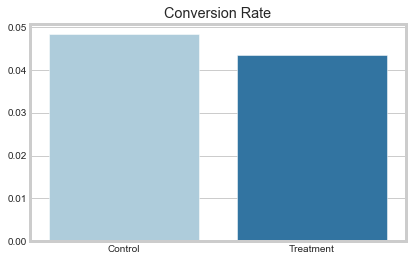

Difference between Control and Treatment -0.00488


In [61]:
sns.set_style("whitegrid")
sns.barplot(x = ['Control', 'Treatment'], y = main.groupby('test')['conversion'].mean().values)
plt.title('Conversion Rate')
plt.show()
print(f'Difference between Control and Treatment {np.round(main.groupby("test")["conversion"].mean()[1] - main.groupby("test")["conversion"].mean()[0], 5)}')

From this it follows that the conversion rate is smaller by 0.4% in treatment group. However, because there is a **selection bias** in the data, this **conclusion is wrong**. We can check it by grouping the data by Country and Test columns:

In [78]:
main.groupby(['country', 'test'])['conversion'].count()

country  test
0        0        9356
         1       37377
1        0        5550
         1        5574
2        0        9853
         1        9884
3        0       27088
         1       26972
4        0        2660
         1        2649
5        0        8036
         1        7859
6        0        4108
         1        4067
7        0        7622
         1        7503
8        0        4361
         1        4207
9        0       64209
         1       64275
10       0        3419
         1        3304
11       0        1966
         1        1985
12       0        3650
         1        3697
13       0       16869
         1       16797
14       0         415
         1        3719
15       0       16149
         1       15905
Name: conversion, dtype: int64

Here we see that countries with indices 0 and 14 have much more Treatment observations than Control. This biases the results. Luckily, CausalML helps us to identify this type of inconsistencies and gives us a more unbiased result.

## CausalML Data Prep
There are a few steps prior to modelling with CausalML:
1. Separate variables into Treatment, Outcome, and Confounders
2. Get Propensity Scores


In [79]:
#Treatment
treatment = main['test']
treatment = np.array(['treatment' if val==1 else 'control' for val in treatment])
pd.Series(treatment).value_counts()

treatment    215774
control      185311
dtype: int64

In [80]:
#Outcome
y = main['conversion']
y.value_counts()

0    382769
1     18316
Name: conversion, dtype: int64

In [65]:
#Confounders
X = main.drop(['user_id', 'conversion', 'test'], axis=1)

Propensity model is build by treating the Treatment variable as dependent, and Confounders as independent variables. If we achieve a model with AUC score larger than 0.5 (random guessing), we can say that we have some sort of a sampling bias.

In [81]:
#Propensity Model
prop_model = LGBMClassifier(colsample_bytree=0.8, subsample = 0.8, n_estimators=300)
cross_val_score(prop_model, X, treatment, cv=5, scoring='roc_auc').mean()

0.5686261774250765

Our model achieves AUC of 0.57, which makes it useful in evaluating the test outcome

In [82]:
#Fitting the model
prop_model.fit(X, treatment)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [84]:
#Getting propensity scores
prop_scores = prop_model.predict_proba(X)

## X meta-learner ATE

In [74]:
#Fitting the X-meta learner
learner_x = BaseXClassifier(learner = LGBMClassifier(colsample_bytree=0.8, num_leaves=50, n_estimators=200),
                            control_effect_learner=LinearRegression(),
                            treatment_effect_learner=LinearRegression(), 
                            control_name='control')

In [85]:
#Getting the average treatment effect with upper and lower bounds
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p = prop_scores[:, 1])

In [86]:
ate_x, ate_x_lb, ate_x_ub

(array([1.88359062e-05]), array([-0.00126076]), array([0.00129843]))

In conclusion, **there is no clear effect of our experiment** on the propensity to convert. This is in contrast to simply comparing the means of treatment and control groups. 